In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output

FILTERED_REGIONS = [
    'Madhya Pradesh',
    'Maharashtra',
    'Delhi',
    'Rajasthan',
    'Tamil Nadu']

FILTERED_REGION_CODES = ['MP', 'MH', 'DL', 'RJ', 'TN']

%config InlineBackend.figure_format = 'retina'


Bad key "axes.titlelocation" on line 298 in
C:\Users\user\Desktop\covid-19\covid-19\matplotlibrc.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# Column vector of k
k = np.arange(0, 70)[:, None]

# Different values of Lambda
lambdas = [10, 20, 30, 40]

# Evaluated the Probability Mass Function (remember: poisson is discrete)
y = sps.poisson.pmf(k, lambdas)

# Show the resulting shape
print(y.shape)

(70, 4)


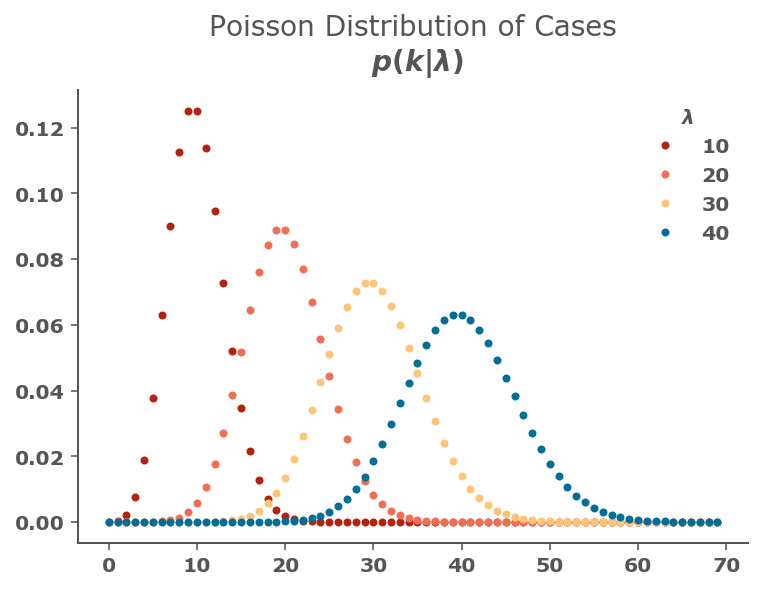

In [3]:
fig, ax = plt.subplots()

ax.set(title='Poisson Distribution of Cases\n $p(k|\lambda)$')

plt.plot(k, y,
         marker='o',
         markersize=3,
         lw=0)

plt.legend(title="$\lambda$", labels=lambdas);

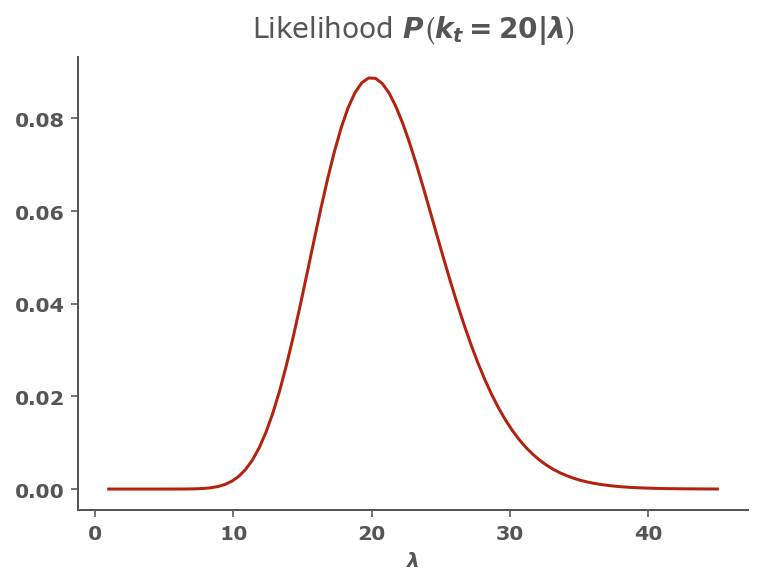

In [4]:
k = 20

lam = np.linspace(1, 45, 90)

likelihood = pd.Series(data=sps.poisson.pmf(k, lam),
                       index=pd.Index(lam, name='$\lambda$'),
                       name='lambda')

likelihood.plot(title=r'Likelihood $P\left(k_t=20|\lambda\right)$');

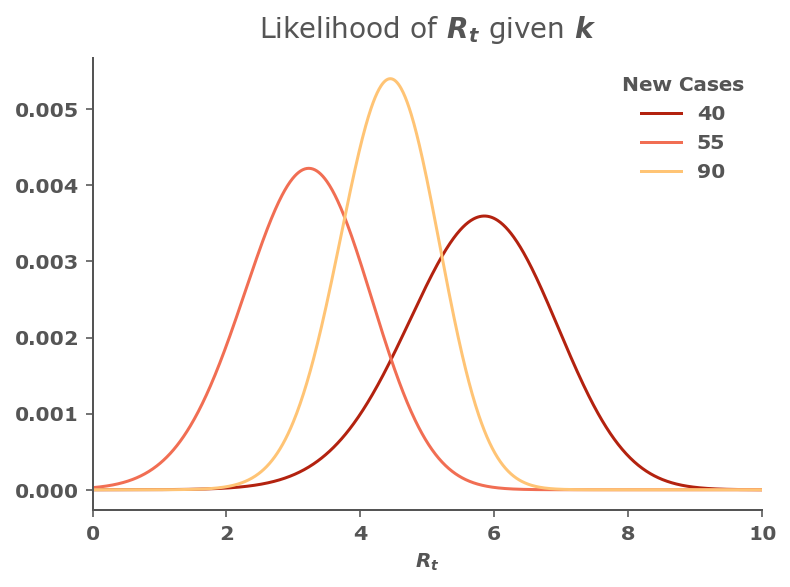

In [5]:
k = np.array([20, 40, 55, 90])

# We create an array for every possible value of Rt
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

# Gamma is 1/serial interval
# https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article
# https://www.nejm.org/doi/full/10.1056/NEJMoa2001316
GAMMA = 1/7

# Map Rt into lambda so we can substitute it into the equation below
# Note that we have N-1 lambdas because on the first day of an outbreak
# you do not know what to expect.
lam = k[:-1] * np.exp(GAMMA * (r_t_range[:, None] - 1))

# Evaluate the likelihood on each day and normalize sum of each day to 1.0
likelihood_r_t = sps.poisson.pmf(k[1:], lam)
likelihood_r_t /= np.sum(likelihood_r_t, axis=0)

# Plot it
ax = pd.DataFrame(
    data = likelihood_r_t,
    index = r_t_range
).plot(
    title='Likelihood of $R_t$ given $k$',
    xlim=(0,10)
)

ax.legend(labels=k[1:], title='New Cases')
ax.set_xlabel('$R_t$');

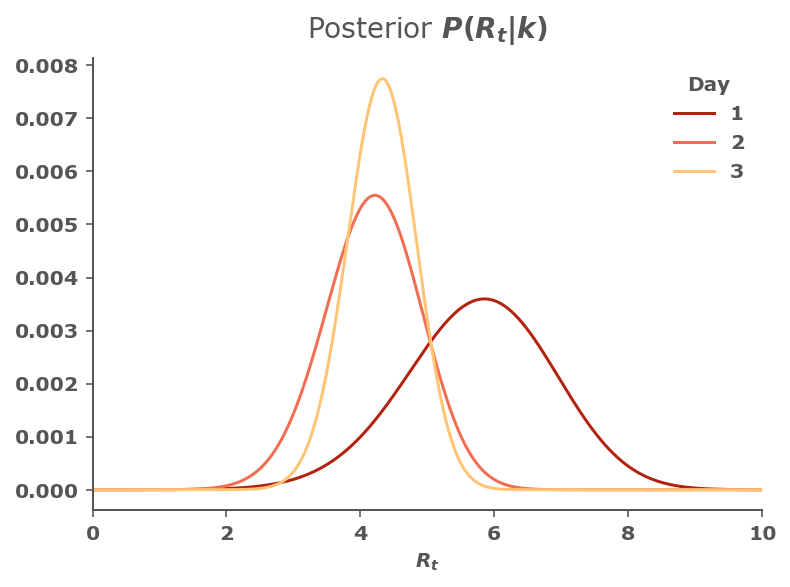

In [6]:
posteriors = likelihood_r_t.cumprod(axis=1)
posteriors = posteriors / np.sum(posteriors, axis=0)

columns = pd.Index(range(1, posteriors.shape[1]+1), name='Day')
posteriors = pd.DataFrame(
    data = posteriors,
    index = r_t_range,
    columns = columns)

ax = posteriors.plot(
    title='Posterior $P(R_t|k)$',
    xlim=(0,10)
)
ax.legend(title='Day')
ax.set_xlabel('$R_t$');

In [7]:

most_likely_values = posteriors.idxmax(axis=0)
most_likely_values

Day
1    5.85
2    4.22
3    4.33
dtype: float64

In [8]:
def highest_density_interval(pmf, p=.9, debug=False):
#     print(pmf.describe())
#     print("hello")
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col], p=p) for col in pmf],index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    
    # N x N matrix of total probability mass for each low, high
    total_p = cumsum - cumsum[:, None]
    
    # Return all indices with total_p > p
    lows, highs = (total_p > p).nonzero()
    
    # Find the smallest range (highest density)
#     print("total_p\n{}lows\n{}highs\n{}".format(total_p,lows,highs))
#     print("\nhighs and lows: ",len(highs),len(lows))
    
#     print(total_p.max())
    if len(lows)>0:
        best = (highs - lows).argmin()

        low = pmf.index[lows[best]]
        high = pmf.index[highs[best]]
    
        return pd.Series([low, high],
                         index=[f'Low_{p*100:.0f}',
                                f'High_{p*100:.0f}'])
    
    else:
        return pd.Series([0, 0],
                         index=[f'Low_{p*100:.0f}',
                                f'High_{p*100:.0f}'])
hdi = highest_density_interval(posteriors, debug=True)
hdi.tail()

,Low_90,High_90
Day,,
1,3.89,7.55
2,2.96,5.33
3,3.42,5.12


In [9]:
posteriors.to_csv("posterior.csv")

In [10]:
posteriors.columns

RangeIndex(start=1, stop=4, step=1, name='Day')

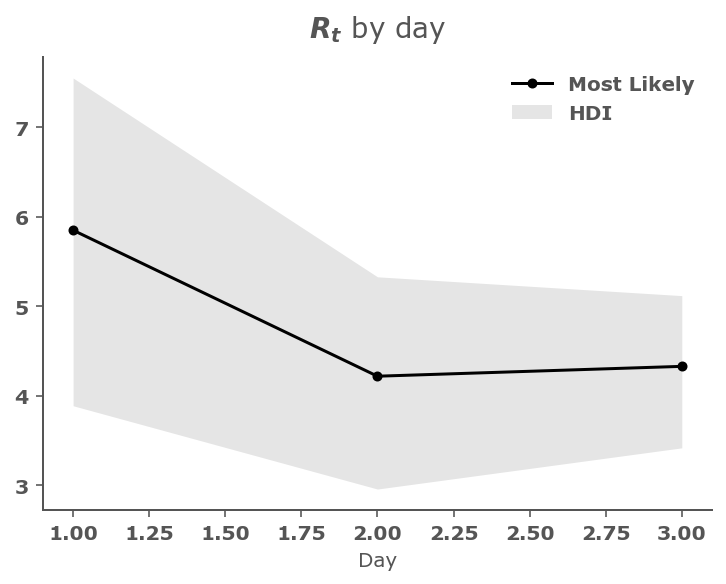

In [11]:
ax = most_likely_values.plot(marker='o',
                             label='Most Likely',
                             title=f'$R_t$ by day',
                             c='k',
                             markersize=4)

ax.fill_between(hdi.index,
                hdi['Low_90'],
                hdi['High_90'],
                color='k',
                alpha=.1,
                lw=0,
                label='HDI')

ax.legend();

# Real world data

In [12]:
states = pd.read_csv('data/covid19.csv',
                     usecols=['date', 'state', 'positive'],
                     parse_dates=['date'],
                     index_col=['state', 'date'],
                     squeeze=True).sort_index()

In [13]:
nameOfStates=pd.read_csv('data/covid19.csv',usecols=['state'])
nameOfStates = nameOfStates.state.unique()

In [14]:
for s in nameOfStates:
    states[s]=states[s].cumsum(axis=0)

In [15]:
for s in nameOfStates:
    print(s)
    print(states[s])

DL
date
2020-04-07      51
2020-04-08     144
2020-04-09     195
2020-04-10     378
2020-04-11     544
2020-04-12     629
2020-04-13     985
2020-04-14    1036
2020-04-15    1053
2020-04-16    1115
2020-04-17    1182
2020-04-18    1368
2020-04-19    1478
2020-04-20    1556
2020-04-21    1631
2020-04-22    1723
2020-04-23    1851
2020-04-24    1989
2020-04-25    2100
2020-04-26    2393
2020-04-27    2583
Name: positive, dtype: int64
GJ
date
2020-04-07      29
2020-04-08      30
2020-04-09     106
2020-04-10     222
2020-04-11     312
2020-04-12     360
2020-04-13     416
2020-04-14     494
2020-04-15     610
2020-04-16     773
2020-04-17     943
2020-04-18    1220
2020-04-19    1587
2020-04-20    1783
2020-04-21    2022
2020-04-22    2251
2020-04-23    2468
2020-04-24    2659
2020-04-25    2915
2020-04-26    3145
2020-04-27    3392
Name: positive, dtype: int64
KA
date
2020-04-07     12
2020-04-08     18
2020-04-09     34
2020-04-10     44
2020-04-11     52
2020-04-12     69
2020-04-13  

smoothed = 
 date
2020-04-07    171.0
2020-04-08    180.0
2020-04-09    190.0
2020-04-10    208.0
2020-04-11    232.0
2020-04-12    256.0
2020-04-13    275.0
2020-04-14    275.0
2020-04-15    271.0
2020-04-16    281.0
2020-04-17    302.0
2020-04-18    352.0
2020-04-19    409.0
2020-04-20    473.0
2020-04-21    515.0
2020-04-22    555.0
2020-04-23    567.0
2020-04-24    577.0
2020-04-25    574.0
2020-04-26    570.0
2020-04-27    543.0
Name: MH cases, dtype: float64


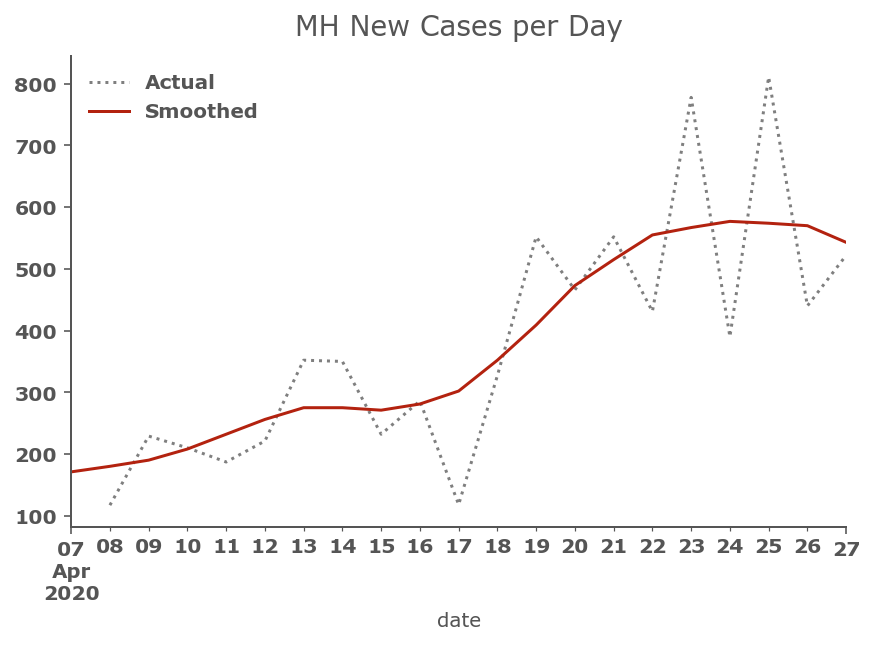

In [42]:
state_name = 'MH'

def prepare_cases(cases, cutoff=5):
    new_cases = cases.diff()
#     new_cases=cases.copy()
#     print('\x1b[1;31m'+'new_cases ='+'\x1b[0m')
#     print(new_cases)

    smoothed = new_cases.rolling(7,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).round()
    print('\x1b[1;31m'+'smoothed ='+'\x1b[0m \n',smoothed)

    idx_start = np.searchsorted(smoothed, cutoff)
    
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    
    return original, smoothed

cases = states.xs(state_name).rename(f"{state_name} cases")
# print(cases)
original, smoothed = prepare_cases(cases)

original.plot(title=f"{state_name} New Cases per Day",
               c='k',
               linestyle=':',
               alpha=.5,
               label='Actual',
               legend=True,
             figsize=(500/72, 300/72))

ax = smoothed.plot(label='Smoothed',
                   legend=True)

ax.get_figure().set_facecolor('w')


In [43]:
def get_posteriors(sr, sigma=0.15):

    # (1) Calculate Lambda
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))
    print("lam\n",lam)

    # (2) Calculate each day's likelihood
    likelihoods = pd.DataFrame(
        data = sps.poisson.pmf(sr[1:].values, lam),
        index = r_t_range,
        columns = sr.index[1:])
    print(likelihoods)
    # (3) Create the Gaussian Matrix
    process_matrix = sps.norm(loc=r_t_range,
                              scale=sigma
                             ).pdf(r_t_range[:, None]) 
    # (3a) Normalize all rows to sum to 1
    process_matrix /= process_matrix.sum(axis=0)
    
    # (4) Calculate the initial prior
    prior0 = sps.gamma(a=4).pdf(r_t_range)
    prior0 /= prior0.sum()

    # Create a DataFrame that will hold our posteriors for each day
    # Insert our prior as the first posterior.
    posteriors = pd.DataFrame(
        index=r_t_range,
        columns=sr.index,
        data={sr.index[0]: prior0}
    )
    
    # We said we'd keep track of the sum of the log of the probability
    # of the data for maximum likelihood calculation.
    log_likelihood = 0.0
    # (5) Iteratively apply Bayes' rule
    for previous_day, current_day in zip(sr.index[:-1], sr.index[1:]):

        #(5a) Calculate the new prior
        current_prior = process_matrix @ posteriors[previous_day]
        
        #(5b) Calculate the numerator of Bayes' Rule: P(k|R_t)P(R_t)
        numerator = likelihoods[current_day] * current_prior
        
        #(5c) Calcluate the denominator of Bayes' Rule P(k)
        denominator = np.sum(numerator)
        print(current_prior,numerator,denominator)
        # Execute full Bayes' Rule
        posteriors[current_day] = numerator/denominator
        
        # Add to the running sum of log likelihoods
        log_likelihood += np.log(denominator)
    return posteriors, log_likelihood

# Note that we're fixing sigma to a value just for the example
posteriors, log_likelihood = get_posteriors(smoothed, sigma=.25)

lam
 [[ 148.23612086  156.03802196  164.70680095 ...  500.18854816
   497.58791446  494.12040286]
 [ 148.44803808  156.26109271  164.94226453 ...  500.90361386
   498.29926232  494.82679359]
 [ 148.66025825  156.48448237  165.17806473 ...  501.61970183
   499.01162712  495.53419418]
 ...
 [ 820.76348396  863.96156206  911.95942662 ... 2769.47678506
  2755.07742569 2735.87827987]
 [ 821.93684114  865.19667488  913.26315682 ... 2773.43600781
  2759.01606323 2739.78947045]
 [ 823.11187573  866.4335534   914.56875081 ... 2777.40089063
  2762.96033141 2743.70625244]]
date      2020-04-08     2020-04-09     2020-04-10     2020-04-11  \
0.00    1.232046e-03   9.150423e-04   1.453874e-04   2.952237e-05   
0.01    1.289045e-03   9.603791e-04   1.546371e-04   3.177901e-05   
0.02    1.348272e-03   1.007641e-03   1.644200e-04   3.419555e-05   
0.03    1.409794e-03   1.056891e-03   1.747628e-04   3.678227e-05   
0.04    1.473674e-03   1.108193e-03   1.856935e-04   3.955004e-05   
...              

In [44]:
posteriors

date,2020-04-07,2020-04-08,2020-04-09,2020-04-10,2020-04-11,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,...,2020-04-18,2020-04-19,2020-04-20,2020-04-21,2020-04-22,2020-04-23,2020-04-24,2020-04-25,2020-04-26,2020-04-27
0.00,0.000000e+00,4.288177e-06,2.039006e-06,2.197756e-07,1.440546e-08,2.972075e-09,4.360458e-09,2.919077e-07,0.000005,0.000002,...,6.125025e-11,5.979030e-14,3.051736e-16,1.388220e-14,1.810915e-13,2.065106e-10,5.092278e-09,1.474237e-07,6.979030e-07,0.000026
0.01,1.653859e-09,4.804217e-06,2.291475e-06,2.520996e-07,1.693336e-08,3.555058e-09,5.239789e-09,3.424016e-07,0.000006,0.000003,...,7.642556e-11,7.846023e-14,4.177910e-16,1.891174e-14,2.454475e-13,2.689712e-10,6.484793e-09,1.825368e-07,8.508780e-07,0.000030
0.02,1.309922e-08,5.376001e-06,2.572960e-06,2.889337e-07,1.988718e-08,4.248244e-09,6.289754e-09,4.011777e-07,0.000007,0.000003,...,9.524724e-11,1.028233e-13,5.711215e-16,2.572128e-14,3.320920e-13,3.496771e-10,8.242604e-09,2.255851e-07,1.035433e-06,0.000036
0.03,4.376997e-08,6.008781e-06,2.886521e-06,3.308709e-07,2.333549e-08,5.071625e-09,7.542079e-09,4.695132e-07,0.000008,0.000004,...,1.185629e-10,1.345724e-13,7.795693e-16,3.492539e-14,4.485355e-13,4.537596e-10,1.045722e-08,2.782572e-07,1.257647e-06,0.000041
0.04,1.027187e-07,6.708221e-06,3.235510e-06,3.785774e-07,2.735736e-08,6.048660e-09,9.034105e-09,5.488681e-07,0.000009,0.000004,...,1.474099e-10,1.758904e-13,1.062520e-15,4.734528e-14,6.047460e-13,5.877341e-10,1.324192e-08,3.425765e-07,1.524671e-06,0.000048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11.96,1.827565e-05,1.536988e-163,3.526076e-270,2.214235e-315,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
11.97,1.813923e-05,6.009038e-164,8.195214e-271,4.167754e-316,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
11.98,1.800379e-05,2.343163e-164,1.900137e-271,7.824199e-317,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
11.99,1.786932e-05,9.112857e-165,4.395058e-272,1.464986e-317,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000


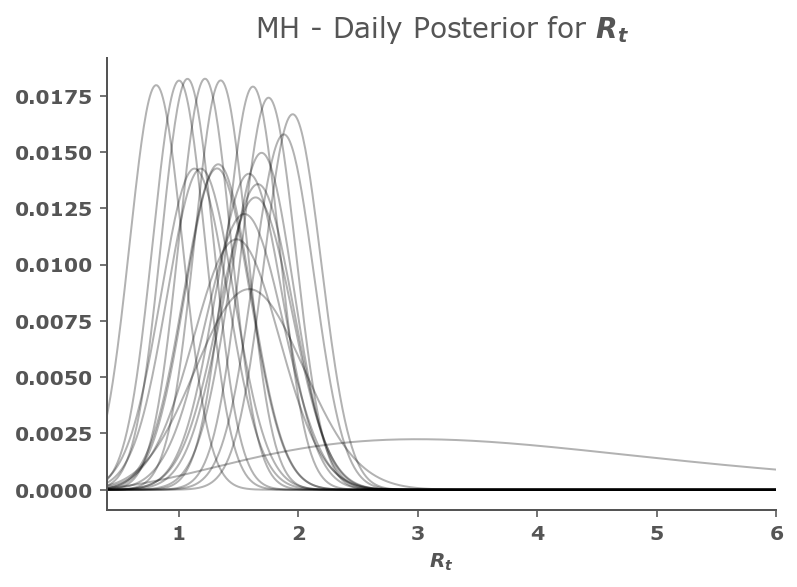

In [45]:
ax = posteriors.plot(title=f'{state_name} - Daily Posterior for $R_t$',
           legend=False, 
           lw=1,
           c='k',
           alpha=.3,
           xlim=(0.4,6))

ax.set_xlabel('$R_t$');

In [46]:
# Note that this takes a while to execute - it's not the most efficient algorithm
hdis = highest_density_interval(posteriors, p=.9)
print(hdis)
most_likely = posteriors.idxmax().rename('ML')
print(most_likely)

# Look into why you shift -1
result = pd.concat([most_likely, hdis], axis=1)

result.tail()

            Low_90  High_90
date                       
2020-04-07    0.86     6.84
2020-04-08    0.86     2.32
2020-04-09    0.87     2.05
2020-04-10    0.97     2.05
2020-04-11    1.09     2.11
2020-04-12    1.15     2.12
2020-04-13    1.09     2.03
2020-04-14    0.85     1.77
2020-04-15    0.66     1.58
2020-04-16    0.72     1.64
2020-04-17    0.85     1.76
2020-04-18    1.23     2.11
2020-04-19    1.42     2.26
2020-04-20    1.53     2.32
2020-04-21    1.34     2.10
2020-04-22    1.22     1.96
2020-04-23    0.95     1.68
2020-04-24    0.85     1.57
2020-04-25    0.70     1.42
2020-04-26    0.60     1.33
2020-04-27    0.44     1.17
date
2020-04-07    3.00
2020-04-08    1.59
2020-04-09    1.48
2020-04-10    1.55
2020-04-11    1.64
2020-04-12    1.66
2020-04-13    1.59
2020-04-14    1.32
2020-04-15    1.13
2020-04-16    1.19
2020-04-17    1.33
2020-04-18    1.69
2020-04-19    1.88
2020-04-20    1.96
2020-04-21    1.75
2020-04-22    1.62
2020-04-23    1.35
2020-04-24    1.22
2020-04-2

,ML,Low_90,High_90
date,,,
2020-04-23,1.35,0.95,1.68
2020-04-24,1.22,0.85,1.57
2020-04-25,1.08,0.70,1.42
2020-04-26,1.00,0.60,1.33
2020-04-27,0.81,0.44,1.17


              ML  Low_90  High_90
date                             
2020-04-07  3.00    0.86     6.84
2020-04-08  1.59    0.86     2.32
2020-04-09  1.48    0.87     2.05
2020-04-10  1.55    0.97     2.05
2020-04-11  1.64    1.09     2.11
2020-04-12  1.66    1.15     2.12
2020-04-13  1.59    1.09     2.03
2020-04-14  1.32    0.85     1.77
2020-04-15  1.13    0.66     1.58
2020-04-16  1.19    0.72     1.64
2020-04-17  1.33    0.85     1.76
2020-04-18  1.69    1.23     2.11
2020-04-19  1.88    1.42     2.26
2020-04-20  1.96    1.53     2.32
2020-04-21  1.75    1.34     2.10
2020-04-22  1.62    1.22     1.96
2020-04-23  1.35    0.95     1.68
2020-04-24  1.22    0.85     1.57
2020-04-25  1.08    0.70     1.42
2020-04-26  1.00    0.60     1.33
2020-04-27  0.81    0.44     1.17
AxesSubplot(0.125,0.125;0.775x0.785)
MH


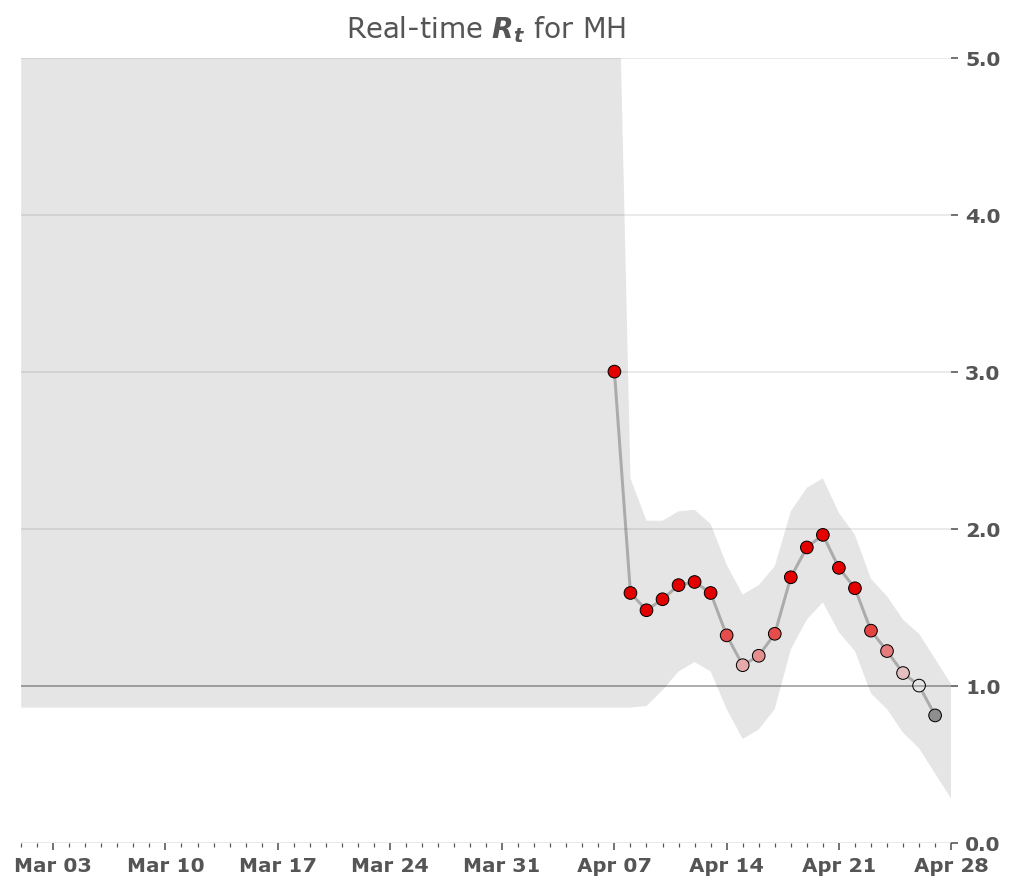

In [47]:
def plot_rt(result, ax, state_name):
    
    ax.set_title(f"{state_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
#     cmap = ListedColormap([0.15,0.31,0.1,1])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('date')
    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low_90'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High_90'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-03-01'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 5.0)
    ax.set_xlim(pd.Timestamp('2020-03-01'), result.index.get_level_values('date')[-1]+pd.Timedelta(days=1))
    fig.set_facecolor('w')

    
fig, ax = plt.subplots(figsize=(600/72,500/72))


print(result)
print(ax)
print(state_name)
plot_rt(result, ax, state_name)
ax.set_title(f'Real-time $R_t$ for {state_name}')
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

In [48]:
sigmas = np.linspace(1/20, 1, 20)

# targets = ~states.index.get_level_values('state').isin(FILTERED_REGION_CODES)
# 

targets = ~states.index.get_level_values('state').isin(['TN'])
states_to_process = states.loc[targets]

results = {}
for state_name, cases in states_to_process.groupby(level='state'):
    
    print(state_name)
    new, smoothed = prepare_cases(cases, cutoff=5)
    
    if len(smoothed) == 0:
        new, smoothed = prepare_cases(cases, cutoff=3)
    print("Smoothed length",len(smoothed))
    result = {}
    print("smoothed", smoothed,smoothed.index)
    # Holds all posteriors with every given value of sigma
    result['posteriors'] = []
    
    # Holds the log likelihood across all k for each value of sigma
    result['log_likelihoods'] = []
    
    for sigma in sigmas:
        print(sigma)
        posteriors, log_likelihood = get_posteriors(smoothed, sigma=sigma)
        result['posteriors'].append(posteriors)
        result['log_likelihoods'].append(log_likelihood)
    
    # Store all results keyed off of state name
    results[state_name] = result
    clear_output(wait=True)

print('Done.')
# print("states_to_process",states_to_process)


Done.


In [49]:
sigmas

array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [50]:
# log_likelihoods of some states are -inf
# checking every state log_likelihood
# removing state with bad log_likelihood

for state_unnamed in results.keys():
    print(state_unnamed)
    print(results[state_unnamed]['log_likelihoods'])
    print("\n")

DL
[-83.75005949333449, -82.80090741845281, -81.86468339961277, -81.10621645652826, -80.50855711595564, -80.0690339897314, -79.81173430838251, -79.72032938056195, -79.75684275604785, -79.88533033084926, -80.07845425072192, -80.31685623967664, -80.5870815387834, -80.8797467602195, -81.18822656074005, -81.50777186005287, -81.83492683023341, -82.16714092363745, -82.50250682173598, -82.83958054765324]


GJ
[-85.8874094919454, -83.66207853581562, -82.22793860369353, -81.40504364440977, -80.95589236421637, -80.74079072114516, -80.67783222361055, -80.72053855159913, -80.84126298422257, -81.02102438324545, -81.24545764746341, -81.50356346701733, -81.78708051708361, -82.08986396670174, -82.40729187879192, -82.735794953466, -83.07253385962406, -83.41519621972112, -83.76187241886925, -84.11097703604779]


KA
[-52.12290976452689, -52.03366680579913, -51.937585197007884, -51.860213784682315, -51.809232386848024, -51.787304003182584, -51.79556436148796, -51.83287794458903, -51.89613294476395, -51.98

[-658.71873636 -651.64150451 -646.58747982 -643.48375284 -641.71481302
 -640.95486737 -641.05837519 -641.84946284 -643.15264467 -644.82832832
 -646.77460844 -648.91924279 -651.21130567 -653.61451712 -656.10241909
 -658.65511195 -661.2571452  -663.8961855  -666.56217475 -669.24678539]


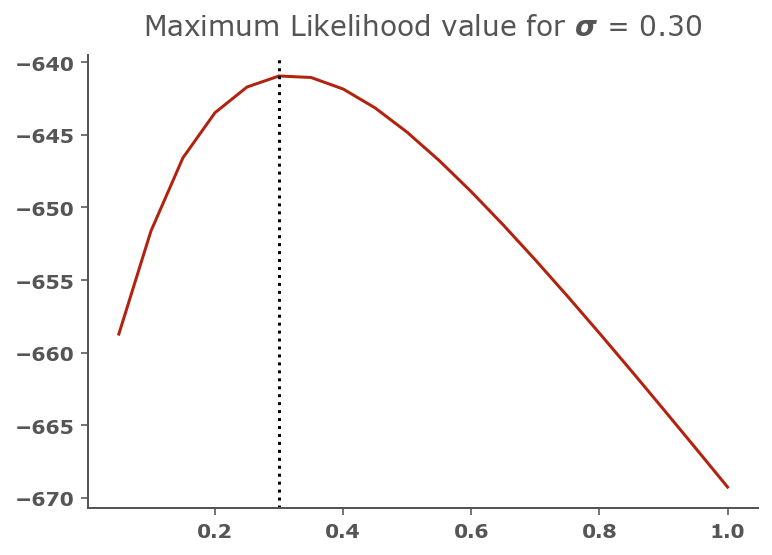

In [51]:
# Each index of this array holds the total of the log likelihoods for
# the corresponding index of the sigmas array.
total_log_likelihoods = np.zeros_like(sigmas)

# Loop through each state's results and add the log likelihoods to the running total.
for state_name, result in results.items():
    total_log_likelihoods += result['log_likelihoods']
print(total_log_likelihoods)
# Select the index with the largest log likelihood total
max_likelihood_index = total_log_likelihoods.argmax()

# Select the value that has the highest log likelihood
sigma = sigmas[max_likelihood_index]
# Plot it
fig, ax = plt.subplots()
ax.set_title(f"Maximum Likelihood value for $\sigma$ = {sigma:.2f}");
ax.plot(sigmas, total_log_likelihoods)
ax.axvline(sigma, color='k', linestyle=":")


In [52]:
final_results = None
print(max_likelihood_index)
for state_name, result in results.items():
    print(state_name)
    posteriors = result['posteriors'][max_likelihood_index]
    hdis_90 = highest_density_interval(posteriors, p=.9)
    hdis_50 = highest_density_interval(posteriors, p=.5)
    most_likely = posteriors.idxmax().rename('ML')
    result = pd.concat([most_likely, hdis_90, hdis_50], axis=1)
    if final_results is None:
        final_results = result
    else:
        final_results = pd.concat([final_results, result])
    clear_output(wait=True)

print('Done.')


Done.


In [53]:
results

{'DL': {'posteriors': [state            DL                                                            \
   date     2020-04-07    2020-04-08     2020-04-09     2020-04-10    2020-04-11   
   0.00   0.000000e+00  1.630004e-08   1.452138e-08   4.483928e-11  6.335110e-12   
   0.01   1.653859e-09  2.407186e-08   1.959694e-08   6.075119e-11  8.569780e-12   
   0.02   1.309922e-08  3.483737e-08   2.613084e-08   8.139957e-11  1.148728e-11   
   0.03   4.376997e-08  4.946164e-08   3.447641e-08   1.080724e-10  1.528876e-11   
   0.04   1.027187e-07  6.896838e-08   4.506224e-08   1.424174e-10  2.023758e-11   
   ...             ...           ...            ...            ...           ...   
   11.96  1.827565e-05  5.213989e-88  1.594845e-186  1.856601e-274  0.000000e+00   
   11.97  1.813923e-05  3.015493e-88  5.519746e-187  3.746073e-275  0.000000e+00   
   11.98  1.800379e-05  1.710279e-88  1.908727e-187  7.536548e-276  0.000000e+00   
   11.99  1.786932e-05  9.487743e-89  6.593537e-188  1.5

## Printing states


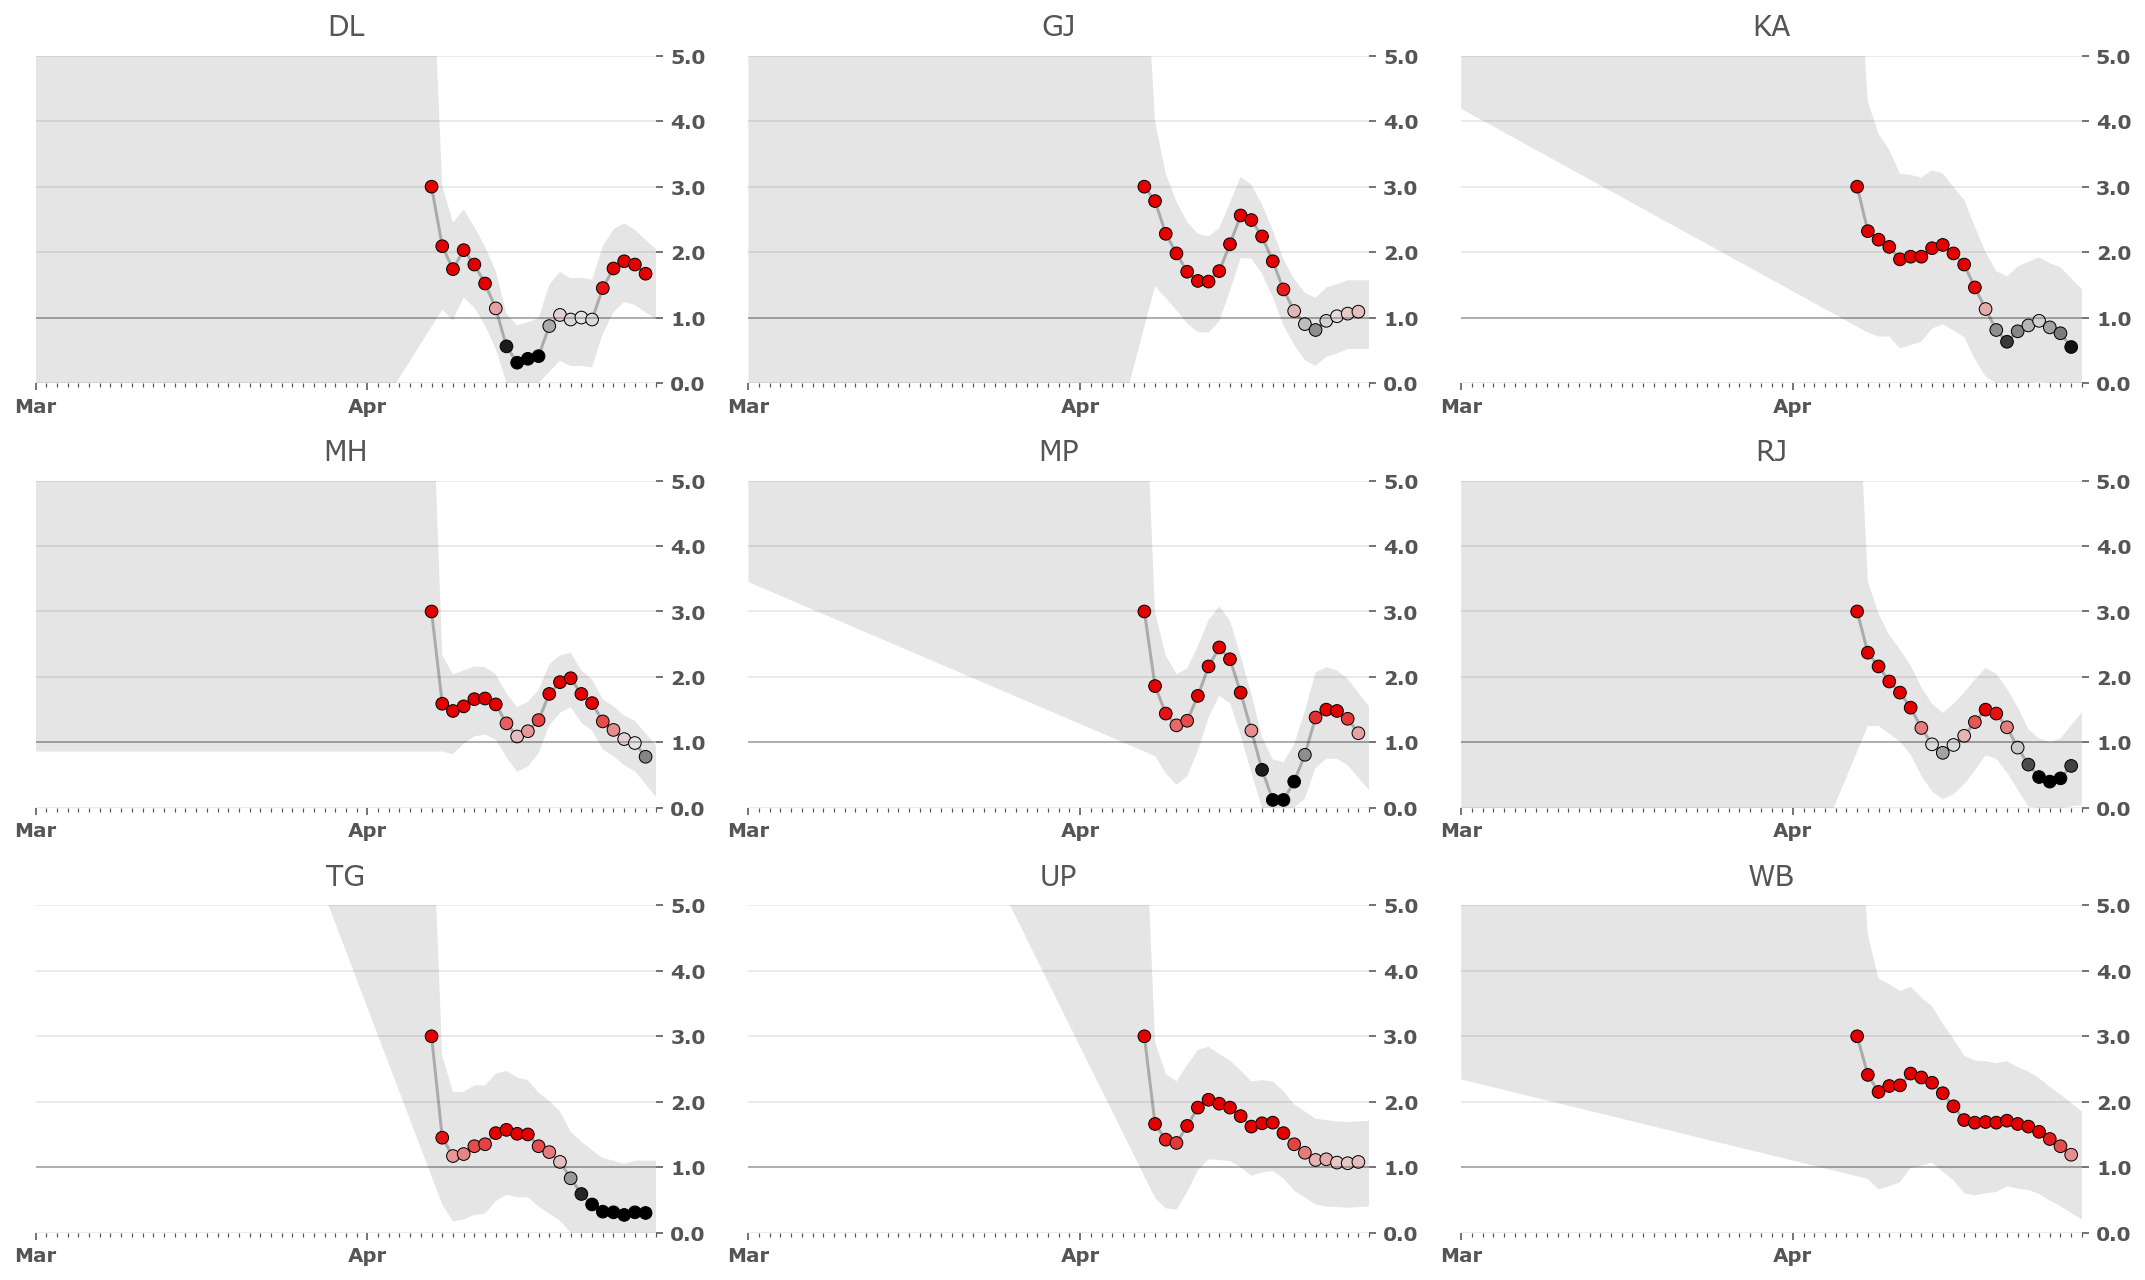

In [54]:
# ncols = 4
# nrows = int(np.ceil(len(results) / ncols))
#uncomment when more states are working
ncols=3
nrows=3

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))

for i, (state_name, result) in enumerate(final_results.groupby('state')):
    plot_rt(result, axes.flat[i], state_name)

fig.tight_layout()
fig.set_facecolor('w')